In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import skimage
import math
from skimage.io import imsave, imread
from skimage.transform import resize
from PIL import Image
from shutil import copyfile
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta, Adam
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16

from keras.layers import BatchNormalization
from keras.optimizers import RMSprop

from keras.utils import np_utils

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.svm import SVC

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [3]:
from preprocess import one_hot
from confusion_matrix import print_confusion_matrix

In [12]:
CATEGORIES_COUNT = 11

In [6]:
VGG16_and_meta_results_path = "C:/Users/svruchtel/Documents/1/Images Classification/images_stacking/"
texts_stacking_results_path = "C:/Users/svruchtel/Documents/1/Texts classification/stacking_just_for_texts/Stacking_Results_USA/"

In [7]:
y_train = np.load(VGG16_and_meta_results_path + "VGG16_y_train_USA.npy")
y_test = np.load(VGG16_and_meta_results_path + "VGG16_y_test_USA.npy")

In [8]:
print(y_train.shape)
print(y_test.shape)

(5531,)
(622,)


In [12]:
images_train_net = np.load(VGG16_and_meta_results_path + "VGG16_meta_net_train_USA.npy")
images_test_net = np.load(VGG16_and_meta_results_path + "VGG16_meta_net_test_USA.npy")

In [26]:
texts_train_net_3_3 = np.load(texts_stacking_results_path + "meta_net_train_3_3_GLOVE_EN_ALL.npy")
texts_test_net_3_3 = np.load(texts_stacking_results_path + "meta_net_test_3_3_GLOVE_EN_ALL.npy")

In [27]:
# texts_train_net_3_3 = texts_train_net_3_3.reshape((texts_train_net_3_3.shape[0], 1))
# texts_test_net_3_3 = texts_test_net_3_3.reshape((texts_test_net_3_3.shape[0], 1))

In [28]:
texts_train_net_3_3.shape

(5531, 11)

In [21]:
images_train_net[0]

array([0.08932365, 0.20780823, 0.00187832, 0.08612917, 0.006549  ,
       0.27448672, 0.01567141, 0.06934767, 0.2116766 , 0.00129538,
       0.03583378], dtype=float32)

In [22]:
def run_knn_uniform(X_train, X_test):
    knn_uniform_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='uniform')
    knn_uniform_15.fit(X_train, y_train)

    acc_knn_uniform_15 = accuracy_score(y_test, knn_uniform_15.predict(X_test))
    print("test accuracy:  %.4f" % acc_knn_uniform_15)
    print("")

    y_train_pred = knn_uniform_15.predict(X_train)
    y_test_pred = knn_uniform_15.predict(X_test)

    print("TRAIN CONFUSION MATRIX")
    print_confusion_matrix(X_train, y_train, y_train_pred, categories_count=CATEGORIES_COUNT)

    print("")
    print("TEST CONFUSION MATRIX")
    print_confusion_matrix(X_test, y_test, y_test_pred, categories_count=CATEGORIES_COUNT)

In [23]:
def run_knn_distance(X_train, X_test):
    knn_distance_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance')
    knn_distance_15.fit(X_train, y_train)

    acc_knn_distance_15 = accuracy_score(y_test, knn_distance_15.predict(X_test))
    print("test accuracy:  %.4f" % acc_knn_distance_15)
    print("")

    y_train_pred = knn_distance_15.predict(X_train)
    y_test_pred = knn_distance_15.predict(X_test)

    print("TRAIN CONFUSION MATRIX")
    print_confusion_matrix(X_train, y_train, y_train_pred, categories_count=CATEGORIES_COUNT)

    print("")
    print("TEST CONFUSION MATRIX")
    print_confusion_matrix(X_test, y_test, y_test_pred, categories_count=CATEGORIES_COUNT)

In [24]:
def run_svm(X_train, X_test):
    svm = SVC(kernel='rbf')
    svm.fit(X_train, y_train)

    acc_svm = accuracy_score(y_test, svm.predict(X_test))
    print("test accuracy:  %.4f" % acc_svm)
    print("")

    y_train_pred = svm.predict(X_train)
    y_test_pred = svm.predict(X_test)

    print("TRAIN CONFUSION MATRIX")
    print_confusion_matrix(X_train, y_train, y_train_pred, categories_count=CATEGORIES_COUNT)

    print("")
    print("TEST CONFUSION MATRIX")
    print_confusion_matrix(X_test, y_test, y_test_pred, categories_count=CATEGORIES_COUNT)

In [25]:
def run_meta_net(X_train, X_test):
    
    categories_count = CATEGORIES_COUNT

    meta_net = Sequential()
    meta_net.add(Dense(512, input_shape=X_train[0].shape))
    meta_net.add(Dropout(0.5))
    meta_net.add(Dense(256))
    meta_net.add(Dropout(0.5))
    meta_net.add(Dense(categories_count, activation='softmax'))
    meta_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(meta_net.summary())
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
    history_callback = meta_net.fit(X_train, one_hot(y_train, categories_count), 
                                validation_data=(X_test, one_hot(y_test, categories_count)), 
                                epochs=300, batch_size=100, callbacks=[callback])

    test_scores = meta_net.evaluate(X_test, one_hot(y_test, CATEGORIES_COUNT), verbose=0)
    
    print("test accuracy:  %.4f" % test_scores[1])
    print("")

    y_train_pred = (meta_net.predict(X_train).round()).argmax(axis=1)
    y_test_pred = (meta_net.predict(X_test).round()).argmax(axis=1)

    print("TRAIN CONFUSION MATRIX")
    print_confusion_matrix(X_train, y_train, y_train_pred, categories_count=CATEGORIES_COUNT)

    print("")
    print("TEST CONFUSION MATRIX")
    print_confusion_matrix(X_test, y_test, y_test_pred, categories_count=CATEGORIES_COUNT)


In [33]:
CATEGORIES_COUNT = 11

In [30]:
X_train = np.concatenate((images_train_net, texts_train_net_3_3), axis=1)
X_test = np.concatenate((images_test_net, texts_test_net_3_3), axis=1)

test accuracy:  0.7942

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 362    0    0    0    0    0    0    0    0    0    0]
 [   0  142    0    0    0    0    0    0    0    0    0]
 [   0    0   65    0    0    0    0    0    0    0    0]
 [   0    0    0  274    0    0    0    0    0    0    0]
 [   0    0    0    0 2492    1    0    0    0    0    0]
 [   0    0    0    0    0  583    0    0    0    0    0]
 [   0    0    0    0    0    0  109    0    0    0    0]
 [   0    0    0    0    0    0    0  738    0    0    0]
 [   0    0    0    0    0    1    0    0  629    0    0]
 [   0    0    0    0    0    1    0    0    0   35    0]
 [   0    0    0    0    0    0    0    0    0    0   99]]
Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000

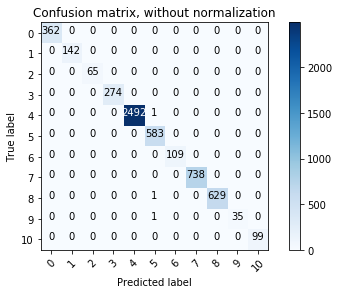

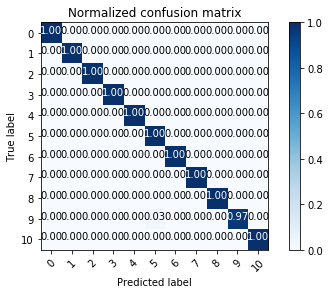


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 41   0   0   0   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   2   0   0   0   3]
 [  0   0   7   0   0   0   1   0   0   0   0]
 [  0   0   0  18   0   1   0  12   0   0   0]
 [ 33   1   0   0 225   9   0  10   0   0   0]
 [  7   0   0   5   2  36   1  11   1   0   2]
 [  0   0   0   0   0   2  11   0   0   0   0]
 [  0   0   0   4   0   4   0  75   0   0   0]
 [  0   0   0   0   0   1   1   1  66   1   1]
 [  0   0   0   0   0   0   2   0   0   1   1]
 [  0   5   0   0   0   1   1   1   1   0   3]]
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.6875     0.         0.         0.         0.
  0.125      0.         0.         0.         0.1875    ]
 [0.         0.         0.875      0.         0.         0.
  0.125      0.         0.         0.         0.        ]
 [0.         0.         0.         0.

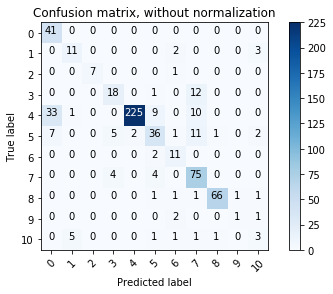

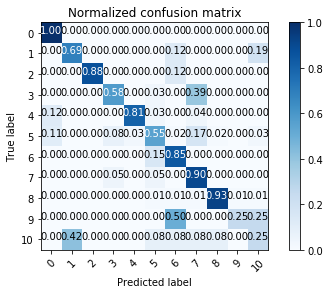

In [34]:
run_knn_distance(X_train, X_test)